In [ ]:
#|default_exp forecast

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

# Forecast

> Full pipeline encapsulation

In [ ]:
#|export
from __future__ import annotations

import reprlib
from typing import Callable, List, Optional, Union

import pandas as pd
from sklearn.base import RegressorMixin

from mlforecast.core import TimeSeries
from mlforecast.utils import backtest_splits

In [ ]:
#|hide
import warnings

from nbdev import show_doc
from sklearn import set_config

In [ ]:
#|hide
set_config(display='text')
warnings.simplefilter('ignore', UserWarning)

In [ ]:
#|export
class Forecast:
    """Full pipeline encapsulation."""
    
    def __init__(
        self,
        models: Union[RegressorMixin, List[RegressorMixin]],  # model or list of models that follow the scikit-learn API
        freq: str,  # pandas offset alias, e.g. D, W, M
        lags: List[int] = [],  # list of lags to use as features
        lag_transforms: Dict[int, List[Tuple]] = {},  # list of transformations to apply to each lag
        date_features: List[str] = [],  # list of names of pandas date attributes to use as features, e.g. dayofweek
        num_threads: int = 1,  # number of threads to use when computing lag features
    ):
        if not isinstance(models, list):
            models = [models]
        self.models = models
        self.ts = TimeSeries(freq, lags, lag_transforms, date_features, num_threads)
        
    def __repr__(self):
        return (
            f'Forecast(models={reprlib.repr(self.models)}, '
            f'freq={self.ts.freq}, '
            f'lag_features={reprlib.repr(self.ts.transforms)}, '
            f'date_features={reprlib.repr(self.ts.date_features)}, '
            f'num_threads={self.ts.num_threads})'
        )
    
    @property
    def freq(self):
        return self.ts.freq

    def preprocess(
        self,
        data: pd.DataFrame,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
    ) -> pd.DataFrame:
        return self.ts.fit_transform(data, static_features, dropna, keep_last_n)

    def fit(
        self,
        data: pd.DataFrame,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,            
        **fit_kwargs,
    ) -> 'Forecast':
        """Preprocesses `data` and fits `model` to it."""
        series_df = self.preprocess(data, static_features, dropna, keep_last_n)
        X, y = series_df.drop(columns=['ds', 'y']), series_df.y.values
        del series_df
        for model in self.models:
            model.fit(X, y, **fit_kwargs)
        return self

    def predict(
        self,
        horizon: int,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,        
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ) -> pd.DataFrame:
        """Compute the predictions for the next `horizon` steps.
        
        `predict_fn(model, new_x, features_order, **predict_fn_kwargs)` is called in every timestep, where:
        `model` is the trained model.
        `new_x` is a dataframe with the same format as the input plus the computed features.
        `features_order` is the list of column names that were used in the training step.
        """
        return self.ts.predict(
            self.models, horizon, dynamic_dfs, predict_fn, **predict_fn_kwargs
        )

    def cross_validation(
        self,
        data,
        n_windows: int,
        window_size: int,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ):
        """Creates `n_windows` splits of `window_size` from `data`, trains the model
        on the training set, predicts the window and merges the actuals and the predictions
        in a dataframe.

        Returns a dataframe containing the datestamps, actual values, train ends and predictions."""
        results = []
        for train_end, train, valid in backtest_splits(data, n_windows, window_size, self.freq):
            self.fit(train, static_features, dropna, keep_last_n)
            y_pred = self.predict(
                window_size, dynamic_dfs, predict_fn, **predict_fn_kwargs
            )
            result = valid[['ds', 'y']].copy()
            result['cutoff'] = train_end
            result = result.merge(y_pred, on=['unique_id', 'ds'], how='left')
            results.append(result)

        from mlforecast.compat import dd_concat
        concat_fn = pd.concat if isinstance(data, pd.DataFrame) else dd_concat
        return concat_fn(results)

The `Forecast` class is a high level abstraction that encapsulates all the steps in the pipeline (preprocessing, fitting the model and computing the predictions). It tries to mimic the scikit-learn API.

## Example
This shows an example with simulated data, for a real world example you can check the [M5 example](https://www.kaggle.com/lemuz90/m5-mlforecast).

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from mlforecast.utils import generate_daily_series, generate_prices_for_series

In order to forecast some time series you need a dataframe with `unique_id` as the index (which contains the identifier for each time serie), a `ds` column with the datestamps and a `y` column with the series values.

### Data setup

In [ ]:
series = generate_daily_series(100, equal_ends=True, n_static_features=2, static_as_categorical=False)
series

,ds,y,static_0,static_1
unique_id,,,,
id_00,2000-10-05,39.811983,79,45
id_00,2000-10-06,103.274013,79,45
id_00,2000-10-07,176.574744,79,45
id_00,2000-10-08,258.987900,79,45
id_00,2000-10-09,344.940404,79,45
...,...,...,...,...
id_99,2001-05-10,453.400509,69,35
id_99,2001-05-11,30.229478,69,35
id_99,2001-05-12,101.313713,69,35


Whatever extra columns you have, like `static_0` and `static_1` here are considered to be static and are replicated when constructing the features for the next datestamp. You can disable this by passing `static_features` to `Forecast.preprocess` or `Forecast.fit` , which will only keep the columns you define there as static. Keep in mind that they will still be used for training, so you'll have to provide them to `Forecast.predict` through the `dynamic_dfs` argument.

### Creating Forecast object

The models can be any scikit-learn compatible regressors.

In [ ]:
models = [
    lgb.LGBMRegressor(n_jobs=1, random_state=0),
    xgb.XGBRegressor(n_jobs=1, random_state=0)
]

fcst = Forecast(
    models=models,
    freq='D',
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    date_features=['dayofweek', 'month'],
    num_threads=2,
)
fcst

Forecast(models=[LGBMRegressor...andom_state=0), XGBRegressor(...bda=None, ...)], freq=<Day>, lag_features=OrderedDict([...e310>), 14))]), date_features=['dayofweek', 'month'], num_threads=2)

Here where we say that:
* Our series have daily frequency.
* We want to use lag 7 as a feature
* We want the lag transformations to be:
   * expanding mean of the lag 1
   * rolling mean of the lag 7 over a window of size 14
* We want to use dayofweek and month as date features.
* We want to perform the preprocessing and the forecasting steps using 2 threads.

From this point we have two options:

1. Preprocess the data and fit our model using all of it.
2. Preprocess the data and get it back as a dataframe to do some custom splitting or adding additional features, then training the model.

#### 1. Using all the data

In [ ]:
show_doc(Forecast.fit)

---

### Forecast.fit

>      Forecast.fit (data:pandas.core.frame.DataFrame,
>                    static_features:Optional[List[str]]=None, dropna:bool=True,
>                    keep_last_n:Optional[int]=None, **fit_kwargs)

Preprocesses `data` and fits `model` to it.

Calling `.fit` on our data performs the preprocessing and uses all the data to train our model.

In [ ]:
fcst.fit(series)

Forecast(models=[LGBMRegressor...andom_state=0), XGBRegressor(...lambda=1, ...)], freq=<Day>, lag_features=OrderedDict([...e310>), 14))]), date_features=['dayofweek', 'month'], num_threads=2)

### Forecasting

In [ ]:
show_doc(Forecast.predict)

---

### Forecast.predict

>      Forecast.predict (horizon:int,
>                        dynamic_dfs:Optional[List[pandas.core.frame.DataFrame]]
>                        =None, predict_fn:Optional[Callable]=None,
>                        **predict_fn_kwargs)

Compute the predictions for the next `horizon` steps.

`predict_fn(model, new_x, features_order, **predict_fn_kwargs)` is called in every timestep, where:
`model` is the trained model.
`new_x` is a dataframe with the same format as the input plus the computed features.
`features_order` is the list of column names that were used in the training step.

Once we have this fitted model, we can compute the forecasts for the next 7 timesteps.

In [ ]:
fcst.predict(7)

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,421.448182,435.328949
id_00,2001-05-16,499.656057,508.972076
id_00,2001-05-17,21.335532,18.983215
id_00,2001-05-18,102.884269,99.284401
id_00,2001-05-19,186.160181,180.996490
...,...,...,...
id_99,2001-05-17,443.481967,435.208649
id_99,2001-05-18,19.476021,21.461609
id_99,2001-05-19,90.335796,92.986107


This uses each prediction as the next value of the target and updates all features accordingly. The static features were propagated and the date features were computed using each new datestamp.

In [ ]:
#|hide
preds = fcst.predict(7)
preds2 = fcst.predict(7)

pd.testing.assert_frame_equal(preds, preds2)

#### 2. Preprocess and train

If we only want to perform the preprocessing step we call `.preprocess` on our data.

In [ ]:
show_doc(Forecast.preprocess)

---

### Forecast.preprocess

>      Forecast.preprocess (data:pandas.core.frame.DataFrame,
>                           static_features:Optional[List[str]]=None,
>                           dropna:bool=True, keep_last_n:Optional[int]=None)

In [ ]:
features_df = fcst.preprocess(series)
features_df.head()

,ds,y,static_0,static_1,lag-7,expanding_mean_lag-1,rolling_mean_lag-7_window_size-14,dayofweek,month
unique_id,,,,,,,,,
id_00,2000-10-25,497.668437,79,45,506.946385,250.013666,263.200596,2,10
id_00,2000-10-26,39.183469,79,45,38.877800,261.806750,263.133868,3,10
id_00,2000-10-27,94.377779,79,45,115.127739,251.687510,263.980563,4,10
id_00,2000-10-28,179.235741,79,45,180.384975,244.847957,264.252723,5,10
id_00,2000-10-29,267.546447,79,45,242.228588,242.114114,263.055629,6,10


This is useful if we want to inspect the data the model will be trained, adding additional features or performing some custom train-valid split. Here we perform a 80-20 split.

In [ ]:
np.random.seed(0)

train_mask = np.random.rand(features_df.shape[0]) < 0.8
train, valid = features_df[train_mask], features_df[~train_mask]
X_train, y_train = train.drop(columns=['ds', 'y']), train.y
X_valid, y_valid = valid.drop(columns=['ds', 'y']), valid.y

If we do this we must "manually" train our model calling `Forecast.model.fit`.

In [ ]:
fcst.models[0].fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',
    verbose=0
)

LGBMRegressor(n_jobs=1, random_state=0)

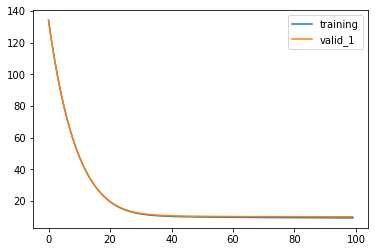

In [ ]:
for lab in fcst.models[0].evals_result_.keys():
    plt.plot(fcst.models[0].evals_result_[lab]['rmse'], label=lab)
plt.legend();

#### Dynamic features

By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features like prices or a calendar with holidays you can pass them as a list to the `dynamic_dfs` argument of `Forecast.predict`, which will call `pd.DataFrame.merge` on each of them in order.

Here's an example:

Suppose that we have a `product_id` column and we have a catalog for prices based on that `product_id` and the date.

In [ ]:
dynamic_series = series.rename(columns={'static_1': 'product_id'})
prices_catalog = generate_prices_for_series(dynamic_series)
prices_catalog

,ds,product_id,price
0,2000-06-09,1,0.548814
1,2000-06-10,1,0.715189
2,2000-06-11,1,0.602763
3,2000-06-12,1,0.544883
4,2000-06-13,1,0.423655
...,...,...,...
20180,2001-05-17,99,0.223520
20181,2001-05-18,99,0.446104
20182,2001-05-19,99,0.044783
20183,2001-05-20,99,0.483216


And you have already merged these prices into your series dataframe.

In [ ]:
series_with_prices = dynamic_series.reset_index().merge(prices_catalog, how='left')
series_with_prices.set_index('unique_id', inplace=True)
series_with_prices

,ds,y,static_0,product_id,price
unique_id,,,,,
id_00,2000-10-05,39.811983,79,45,0.570826
id_00,2000-10-06,103.274013,79,45,0.260562
id_00,2000-10-07,176.574744,79,45,0.274048
id_00,2000-10-08,258.987900,79,45,0.433878
id_00,2000-10-09,344.940404,79,45,0.653738
...,...,...,...,...,...
id_99,2001-05-10,453.400509,69,35,0.792152
id_99,2001-05-11,30.229478,69,35,0.782687
id_99,2001-05-12,101.313713,69,35,0.019463


This dataframe will be passed to `Forecast.fit` (or `Forecast.preprocess`), however since the price is dynamic we have to tell that method that only `static_0` and `product_id` are static and we'll have to update `price` in every timestep, which basically involves merging the updated features with the prices catalog.

In [ ]:
fcst.fit(series_with_prices, static_features=['static_0', 'product_id'])

Forecast(models=[LGBMRegressor...andom_state=0), XGBRegressor(...lambda=1, ...)], freq=<Day>, lag_features=OrderedDict([...e310>), 14))]), date_features=['dayofweek', 'month'], num_threads=2)

The features used for training are stored in `Forecast.ts.features_order_`, as you can see `price` was used for training.

In [ ]:
fcst.ts.features_order_

Index(['static_0', 'product_id', 'price', 'lag-7', 'expanding_mean_lag-1',
       'rolling_mean_lag-7_window_size-14', 'dayofweek', 'month'],
      dtype='object')

So in order to update the price in each timestep we just call `Forecast.predict` with our forecast horizon and pass the prices catalog as a dynamic dataframe.

In [ ]:
preds = fcst.predict(7, dynamic_dfs=[prices_catalog])
preds

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,425.271062,438.075714
id_00,2001-05-16,499.367199,499.328644
id_00,2001-05-17,19.680575,19.650190
id_00,2001-05-18,103.003798,98.412605
id_00,2001-05-19,186.687089,185.415588
...,...,...,...
id_99,2001-05-17,441.140547,439.250183
id_99,2001-05-18,19.506097,19.749830
id_99,2001-05-19,91.141189,88.620872


#### Custom predictions
As you may have noticed `Forecast.predict` can take a `predict_fn` and `predict_fn_kwargs`. By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features you can pass them as a list to `Forecast.predict` in the `dynamic_dfs` argument. However, if you want to do something else, you can define your own function which will take:

* The trained model.
* The updated features (static + transformations + date features).
* A list of dataframes with the dynamic features.
* The order of the features the model was trained on.
* Additional keyword arguments passed to `Forecast.predict`.

Here's an example:

Suppose that we want to scale our predictions so that our series are updated with these scaled values. We can achieve that with the following.

In [ ]:
def scaling_predict_fn(
    model,
    new_x,
    dynamic_dfs,
    features_order,
    scale_factor,
) -> np.ndarray:
    new_x = new_x.drop(columns='ds')
    predictions = model.predict(new_x)
    return scale_factor * predictions

And now we just pass this function to `Forecast.predict`.

In [ ]:
fcst = Forecast(models, freq='D', lags=[7])
fcst.fit(series)

scale_factor = 1.1
preds = fcst.predict(2, predict_fn=scaling_predict_fn, scale_factor=scale_factor)
preds

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,462.984618,468.498840
id_00,2001-05-16,547.728357,550.042603
id_01,2001-05-15,128.083377,129.819885
id_01,2001-05-16,164.265438,165.137360
id_02,2001-05-15,163.398258,161.620834
...,...,...,...
id_97,2001-05-16,388.652115,396.391449
id_98,2001-05-15,82.683279,84.208214
id_98,2001-05-16,104.768186,105.722870


In [ ]:
#|hide
fcst.ts._predict_setup()

for attr in ('head', 'tail'):
    new_x = fcst.ts._update_features().drop(columns='ds')
    original_preds = fcst.models[0].predict(new_x)
    
    expected = scale_factor * original_preds
    actual = getattr(preds.groupby('unique_id')[models[0].__class__.__name__], attr)(1).values
    np.testing.assert_equal(expected, actual)
    
    fcst.ts._update_y(actual)

### Cross validation

If we would like to know how good our forecast will be for a specific model and set of features then we can perform cross validation. What cross validation does is take our data and split it in two parts, where the first part is used for training and the second one for validation. Since the data is time dependant we usually take the last *x* observations from our data as the validation set.

This process is implemented in `Forecast.cross_validation`, which takes our data and performs the process described above for `n_windows` times where each window is of size `window_size`. For example, if we have 100 samples and we want to perform 2 backtests each of size 14, the splits will be as follows:

1. Train: 1 to 72. Validation: 73 to 86.
2. Train: 1 to 86. Validation: 87 to 100.

In [ ]:
show_doc(Forecast.cross_validation)

---

### Forecast.cross_validation

>      Forecast.cross_validation (data, n_windows:int, window_size:int,
>                                 static_features:Optional[List[str]]=None,
>                                 dropna:bool=True,
>                                 keep_last_n:Optional[int]=None, dynamic_dfs:Op
>                                 tional[List[pandas.core.frame.DataFrame]]=None
>                                 , predict_fn:Optional[Callable]=None,
>                                 **predict_fn_kwargs)

Creates `n_windows` splits of `window_size` from `data`, trains the model
on the training set, predicts the window and merges the actuals and the predictions
in a dataframe.

Returns a dataframe containing the datestamps, actual values, train ends and predictions.

In [ ]:
n_windows = 2
window_size = 14

backtest_results = fcst.cross_validation(series, n_windows, window_size)
backtest_results.head()

,ds,y,cutoff,LGBMRegressor,XGBRegressor
unique_id,,,,,
id_00,2001-04-17,404.993322,2001-04-16,414.120640,414.053894
id_00,2001-04-18,508.883226,2001-04-16,494.788381,493.429382
id_00,2001-04-19,1.218119,2001-04-16,20.517266,20.233250
id_00,2001-04-20,109.879770,2001-04-16,100.175775,99.855011
id_00,2001-04-21,163.703847,2001-04-16,187.106175,185.735733


We can aggregate these by date to get a rough estimate of how our model is doing.

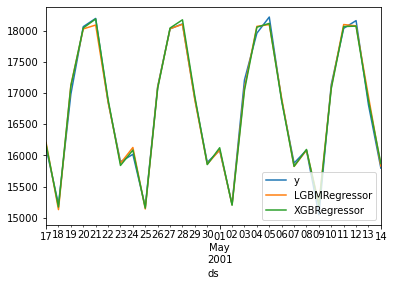

In [ ]:
agg_results = backtest_results.groupby('ds').sum()
agg_results.plot();

We can include some more context by using the values in the training set.

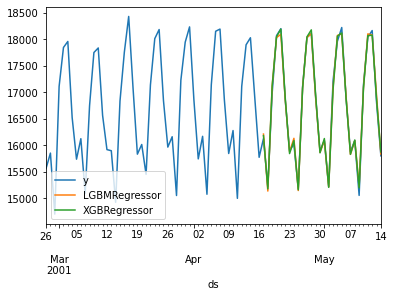

In [ ]:
history = series[series.ds < agg_results.index.min()]
agg_history = history.groupby('ds')[['y']].sum().tail(50)
pd.concat([agg_history, agg_results]).plot();

We can also compute the error for each model.

In [ ]:
{model: np.round(mean_squared_error(backtest_results['y'], backtest_results[model]), 2)
 for model in backtest_results.columns.drop(['ds', 'y', 'cutoff'])}

{'LGBMRegressor': 91.72, 'XGBRegressor': 88.57}

In [ ]:
#|hide
fcst = Forecast(lgb.LGBMRegressor(), freq='D', lags=[7, 14])
backtest_results = fcst.cross_validation(series, n_windows, window_size)
manual_results = []
for cutoff, train, valid in backtest_splits(series, n_windows, window_size, fcst.freq):
    fcst.fit(train)
    pred = fcst.predict(window_size)
    res = valid[['ds', 'y']].copy()
    res['cutoff'] = cutoff
    manual_results.append(res.merge(pred, on=['unique_id', 'ds'], how='left'))
manual_results = pd.concat(manual_results)
pd.testing.assert_frame_equal(backtest_results, manual_results)